In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display

import numpy as np
import randomcate
import plot

In [3]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, f1_score, matthews_corrcoef, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [4]:
CAREER_LENGTH = 1

#EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3]
EARLY_CAREER = 3
#RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
RECOGNITION_CUT_OFF_LIST = [3]
RECOGNITION_CUT = 3

MAX_CAREER_LEN = 15
END_YEAR = 2016

In [48]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended_all2.csv')
print(credible_authors.shape)

(1688735, 82)


In [14]:
team_size_year = pd.read_csv('derived-data/team_size_avg_per_year.csv')

In [15]:
years = sorted(credible_authors.start_year.unique())
COHORT_START_YEARS = [y for y in years if y < (END_YEAR - MAX_CAREER_LEN)]

In [16]:
#credible_authors.columns
#print(credible_authors.groupby("start_year")['dropped_after_10'].agg('sum'))
#print(credible_authors.groupby("start_year")['author'].count())

In [17]:
credible_authors = credible_authors[credible_authors.career_length >= CAREER_LENGTH]
print(credible_authors.shape)
print(CAREER_LENGTH)
print(credible_authors.start_year.unique())

credible_authors = credible_authors[credible_authors.start_year.isin(COHORT_START_YEARS)]

print(credible_authors.shape)
print(COHORT_START_YEARS)

(1688735, 82)
1
[2001 2009 2011 1992 2017 2002 2003 2010 2008 1979 2007 1995 2016 2015
 1986 2005 2012 1998 2006 2013 1999 1980 2014 1988 1996 1970 2004 1994
 1997 1987 1982 2000 1990 1989 1985 1974 1977 1993 1991 1975 1984 1983
 1973 1972 1971 1981 1978 1976 2018]
(292443, 82)
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]


## Linear reg

### Test different predictors

In [ ]:
# test different early career lenghts

In [ ]:
year = 1995

credible_authors_1991 = credible_authors[credible_authors.start_year == year]

In [ ]:
X = credible_authors_1991.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    X = X.join(pd.get_dummies(X[categorical_cols]))

X.drop(categorical_cols, axis=1, inplace=True)

In [ ]:
def run_linear(func, name):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            reg = func.fit(H, y)
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': reg.score(H, y)}, ignore_index=True)
    return df

In [ ]:
def run_cv(func, name, cv, y_col='succ_after_15y'):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            y = X[y_col]
            score = np.mean(cross_val_score(func, H, y, cv=cv, scoring='r2'))
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': score}, ignore_index=True)
    return df

In [ ]:
df1 = run_cv(LinearRegression(), 'linear', cv=3)

In [ ]:
# df1_null = run_cv(LinearRegression(), 'linear_null', cv=3, y_col='succ_shuffled')

In [ ]:
df2 = run_cv(ElasticNet(), 'elastic', cv=3)

In [ ]:
df3 = run_cv(ElasticNetCV(cv=3), 'elastic_CV', cv=3)

In [ ]:
df4 = run_cv(Lasso(alpha=0.1), 'lasso', cv=3)

In [ ]:
# Decision tree overfits pretty bad. Maybe GridParam Search?
df5 = run_cv(DecisionTreeRegressor(), 'tree', cv=3)

In [ ]:
df6 = run_cv(RandomForestRegressor(), 'forest', cv=3)

In [ ]:
# df6_null = run_cv(RandomForestRegressor(), 'forest_null', cv=3, y_col='succ_shuffled')

In [ ]:
dfs = [df1, df2, df3, df4, df5, df6] #df1_null, df6_null
for df_ in dfs: df_.set_index('params', inplace=True)

In [ ]:
dfs[0].join(dfs[1:])

### Elastic net

In [18]:
# EARLY_CAREER = EARLY_CAREER_LEN_LIST[0]
# RECOGNITION_CUT = RECOGNITION_CUT_OFF_LIST[0]
# EARLY_CAREER_LEN_LIST = [3,5,7,9,11,12]
# RECOGNITION_CUT_OFF_LIST = [3,5,7,9,11,12]

In [19]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [20]:
dropped_percent = credible_authors.groupby('start_year')['dropped_after_10'].sum() / credible_authors.groupby('start_year')['dropped_after_10'].count()
dropped_percent = dropped_percent.to_frame().T

dropped_percent_agg = credible_authors['dropped_after_10'].sum() / credible_authors['dropped_after_10'].count()

In [21]:
credible_authors_stayed = credible_authors[credible_authors['dropped_after_10'] == False].copy()

In [22]:
# 4 groups of features: productivity, social capital, quality/rec and gender
def make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, 
                    INCLUDE_VENUE, INCLUDE_YEAR, EARLY_CAREER, RECOGNITION_CUT, dep_var):
    categorical_cols = []
    cols_std = []

    if INCLUDE_YEAR:
        cols_std.append("start_year")
    #scale dependant var
    if dep_var == "dropped_after_10":
        categorical_cols.append(dep_var)
    else:
        cols_std.append(dep_var)

    if INCLUDE_PROD:
        cols_std.append(f'early_career_prod_{EARLY_CAREER}')
        cols_std.append(f'ec_first_auth_{EARLY_CAREER}')

    if INCLUDE_SOCIAL:
        cols_std.append(f'early_career_degree_{EARLY_CAREER}')
        cols_std.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
        cols_std.append(f'team_size_median_{EARLY_CAREER}')
    #     cols_std.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')

    if INCLUDE_REC:
        cols_std.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')

    if INCLUDE_QUALITY:
        cols_std.append(f'early_career_qual_{EARLY_CAREER}')
        cols_std.append(f'early_career_qual_first_{EARLY_CAREER}')

    if INCLUDE_GENDER:
        categorical_cols.append('gender')

    if INCLUDE_VENUE:
        cols_std.extend([f'quantiles_bin_{EARLY_CAREER}']) #'deciles_min_3''quantiles_min_3', 'quantiles_bin_3'
    
    return cols_std, categorical_cols #cols_all, 

In [23]:
from sklearn.metrics import make_scorer
def adjusted_r2(y_true, y_pred, num_feat):
#     print(f"Num features: {num_feat}")
    r2 = r2_score(y_true, y_pred)
    num_sample = len(y_true)
    adj = 1 - float(num_sample-1)/(num_sample-num_feat-1)*(1 - r2)
    return adj

In [33]:
# TODO we scale data every time we train. Modify to keep data and add remove parameters. Somehow separate the prep from train
def scale_columns(X):
    if len(X.columns) > 0:
        scaler = RobustScaler().fit(X)
#         print(scaler.mean_)
        standardized_cols = scaler.transform(X)
    else: 
        standardized_cols = []
    return pd.DataFrame(standardized_cols, index=X.index, columns=X.columns)

def prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, aggr=False):
    X = credible_authors[credible_authors.start_year.isin(COHORT_START_YEARS)].copy()
    
    # Either scale OR INCLUDE start_year as control Var
    # scale dependent variables per year --> WE SHOULD ALSO SCALE OUTCOME VAR
    
    if not aggr:
        for year in COHORT_START_YEARS:
            X.loc[X.start_year == year, cols_std] = scale_columns(X.loc[X.start_year == year, cols_std])
    else:
#     scale over whole dataset
        X[cols_std] = scale_columns(X[cols_std])
    
    # make dummies of categorical cols
    if len(categorical_cols)>0:
        cat_cols = pd.get_dummies(X[categorical_cols]) 
        X = X[cols_std].join(cat_cols)
    else:
        X = X[cols_std]
    if REMOVE_NONE_AUTHORS:
        X.drop('gender_none' , axis=1)
    X['start_year'] = credible_authors['start_year']
    return X

def run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, INCLUDE_YEAR, REMOVE_NONE_AUTHORS, dep_var):
    X = prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, aggr=True)
    Y = X[dep_var].copy()
    X = X.drop(dep_var, axis=1)
#     Y = credible_authors[dep_var]
   
    if not INCLUDE_YEAR:
        X = X.drop('start_year' , axis=1)
        
    feat_table = run_elastic_net(X, Y)
    feat_table = feat_table.set_index(0)
    
    if dep_var == 'dropped_after_10': 
        feat_table = feat_table.append(pd.DataFrame(index=['drop_percentage'], data=[dropped_percent_agg], columns=[1]))
    return feat_table

def run_elastic_net_cohort(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, dep_var):
    table_list = []
    X = prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS)
    # TODO This means we are scaling data over whole dataset even for cohort analysis!
    for year in COHORT_START_YEARS:
        X_year = X[X.start_year == year]
#         y_year = credible_authors[credible_authors.start_year == year][dep_var]
        y_year = X_year[dep_var].copy()
        X_year = X_year.drop(dep_var, axis=1)
#         print(year, end=' ')
        feat_data = run_elastic_net(X_year.drop('start_year', axis=1), y_year)
        feat_data = feat_data.set_index(0)
        feat_data.rename(index=str, columns={1: year}, inplace=True)
        table_list.append(feat_data)
       
    table = pd.DataFrame(index=table_list[0].index)
    for x in table_list: table=table.join(x)
    if dep_var == 'dropped_after_10': table = table.append(dropped_percent)
    return table

def run_elastic_net(X, y):
    # train model and do cross validation

    # add dummy var if no features are given
    # TODO is this still used?
    if X.empty:
        X = pd.DataFrame(1, index=np.arange(len(y)), columns=["dummy"])
    
    kf = KFold(10, True)
    
    if y.nunique()==2:   
        y = y.astype(int)
        #f1, average_precision, roc_auc
        cv_dict = cross_validate(LogisticRegressionCV(cv=10, penalty='l2', max_iter=200), X, y, 
                                 scoring=["f1_micro","f1_macro","f1_weighted","average_precision"], cv=kf, return_estimator=True, return_train_score=False)
        net_coef = pd.DataFrame([es.coef_[0] for es in cv_dict['estimator']], columns=X.columns)
        score = np.mean(cv_dict['test_f1_micro'])
        score2 = np.mean(cv_dict['test_f1_macro'])
        score3 = np.mean(cv_dict['test_f1_weighted'])
        score4 = np.mean(cv_dict['test_average_precision'])
    else:
        adj_r2_scorer = make_scorer(adjusted_r2, num_feat=X.shape[1])
        
        cv_dict = cross_validate(ElasticNetCV(cv=10), X, y, scoring={
            'r2':make_scorer(r2_score), 'neg_mean_squared_error': make_scorer(mean_squared_error), 'adj_r2': adj_r2_scorer},
                                 cv=kf, return_estimator=True, return_train_score=False)

        net_coef = pd.DataFrame([es.coef_ for es in cv_dict['estimator']], columns=X.columns)
        score = np.mean(cv_dict['test_r2'])
        score2 = abs(np.mean(cv_dict['test_neg_mean_squared_error']))
        score3 = np.mean(cv_dict['test_adj_r2'])

    # save the intercepts
    net_intercept = np.mean([es.intercept_ for es in cv_dict['estimator']])
    # take the mean and std from coefs
    net_coef_mean = net_coef.mean()
    net_coef_std = net_coef.std()
    rounding = 2
    net_coef_mean_std = list(zip(np.round(net_coef_mean.values,rounding), np.round(net_coef_std.values,rounding)))
    net_coef_mean_std = [f"{x[0]}({x[1]})" for x in net_coef_mean_std]

    cohort_size = len(y)
    if y.nunique()!=2:
        net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), np.round(score3, rounding), np.round(score2, rounding), cohort_size])
        feat_table = pd.DataFrame(list(zip(np.append(X.columns, ['intercept', 'r2', 'adj_r2', 'neg_mean_squared_error', 'cohort_size']), net_coef_mean_std)))
    else:
        net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), np.round(score2, rounding), np.round(score3, rounding), np.round(score4, rounding), cohort_size])
        feat_table = pd.DataFrame(list(zip(np.append(X.columns, ['intercept', 'f1_micro','f1_macro','f1_weighted', 'avg_precision', 'cohort_size']), net_coef_mean_std)))
    return feat_table

In [34]:
# Stuff that we potentially use as outcome Vars
# dv_hindex = 'h-index_15'
# dv_citations = 'succ_after_15y'

dv_hindex_incr = f'h_index_increase_15_{EARLY_CAREER}'
dv_citations_incr = f'citation_increase_15_{EARLY_CAREER}'
dv_dropped = 'dropped_after_10'

DV = dv_hindex_incr

# check if outcome vars are plausible
# #print(credible_authors.columns)
# credible_authors[["start_year", "succ_after_15y"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "h_index_increase_15_3"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "citation_increase_15_3"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "avg_absence-0-15"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "dropped_after_10"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "total_num_pub"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "career_length"]].groupby("start_year").mean().plot()

## Cohort Elastic Net Models
We compare the predictive performance across cohorts. We should plot R2 and F1 over cohorts.
Is predictive performance stable?

In [35]:
def make_result_table(feature_table):
    results = feature_table.transpose()
    #shorten column names
    new_cols = dict(zip(results.columns, [col.replace('early_career', 'ec') for col in results.columns]))

    results.rename(new_cols, axis='columns', inplace=True)
    results.rename({'feature':'cohort','ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)
    return results
def results_to_latex(results, name):
    ltx_file = open(f"results_{name}.tex", "w")
    ltx_file.write('\n'.join(results.to_latex().split('\n')[5:-7]))
    ltx_file.write('\hline \n')
    ltx_file.write('\n'.join(results.to_latex().split('\n')[-7:-3]))
    ltx_file.close()

In [60]:
def get_baseline_vars():
    INCLUDE_PROD = 0
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 0
    INCLUDE_QUALITY = 0
    INCLUDE_GENDER = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_human_cap_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 1
    INCLUDE_QUALITY = 0
    INCLUDE_GENDER = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_gender_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_social_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_symbolic_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 1
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_full_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 1
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 1
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR

# Run the elastic net across cohorts
def elastic_cohort(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV):
    params = params_func()
    cols_std, categorical_cols = make_cols_lists(*params, EARLY_CAREER, RECOGNITION_CUT, DV)
#     print(cols_std)
    REMOVE_NONE_AUTHORS = params[-3]
    res = run_elastic_net_cohort(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, DV)
    res = make_result_table(res)
    return res
def elastic_agg(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV):
    params = params_func()
    cols_std, categorical_cols = make_cols_lists(*params, EARLY_CAREER, RECOGNITION_CUT, DV)
    INCLUDE_YEAR = params[-1]
    REMOVE_NONE_AUTHORS = params[-3]
    res_agg = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, INCLUDE_YEAR, REMOVE_NONE_AUTHORS, DV)
    return res_agg
# Run the elastic net across grouped data, for all variations
def elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, DV):
    params_func_list = [get_baseline_vars, get_human_cap_vars, get_gender_vars, get_social_vars, get_symbolic_vars, get_full_vars]
    res_agg_list = [elastic_agg(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV) for params_func in params_func_list]
    res_all_agg = pd.DataFrame(index=res_agg_list[-1].index, data=[])
    res_all_agg['baseline'] = res_agg_list[0]
    res_all_agg['human'] = res_agg_list[1]
    res_all_agg['gender'] = res_agg_list[2]
    res_all_agg['social'] = res_agg_list[3]
    res_all_agg['symbolic'] = res_agg_list[4]
    res_all_agg['full_model'] = res_agg_list[5]
    if DV == 'dropped_after_10':
        reorderlist = ['start_year', 'early_career_prod_3', 'ec_first_auth_3', 'early_career_recognition_EC3_RC3',
                   'gender_f', 'gender_m', 'gender_none', 
                   'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3',
                   'quantiles_bin_3', 'early_career_qual_3', 'early_career_qual_first_3',
                   'cohort_size', 'drop_percentage','avg_precision', 'f1_micro','f1_macro','f1_weighted']
        res_all_agg = res_all_agg.reindex(reorderlist)
        res_all_agg = res_all_agg.fillna('')
        res_all_agg['names'] = ['Start year', 'Productivity', 'Productivity (1st)', 'Recognition',
                       'Male', 'Female', 'Undetected',  
                       'Social support', 'Senior support', 'Median team size',
                       'Top venue', 'Ability', 'Ability (1st)',
                       'Cohort size', '% dropouts','Average precision', 'F1 micro','F1 macro','F1 weighted']
    else:
        reorderlist = ['start_year', 'early_career_prod_3', 'ec_first_auth_3', 'early_career_recognition_EC3_RC3',
                   'gender_f', 'gender_m', 'gender_none', 
                   'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3',
                   'quantiles_bin_3', 'early_career_qual_3',  'early_career_qual_first_3',
                   'cohort_size', 'neg_mean_squared_error', 'intercept','r2', 'adjr2']
        res_all_agg = res_all_agg.reindex(reorderlist)
        res_all_agg = res_all_agg.fillna('')
        res_all_agg['names'] = ['Start year', 'Productivity', 'Productivity (1st)', 'Recognition', 
                       'Male', 'Female', 'Undetected', 
                       'Social support', 'Senior support', 'Median team size',
                       'Top venue', 'Ability', 'Ability (1st)',
                       'Cohort size', 'MSE', 'intercept','R2', 'Adjusted R2']
    res_all_agg = res_all_agg.set_index('names')
    return res_all_agg
def get_report_from_table(result_table):
    report = []
    for col in result_table.columns[:-4]:
        float_vals = result_table[col].apply(lambda x: float(x.split('(')[0]))
        num_positive = float_vals.gt(0).sum()
        num_neg = float_vals.lt(0).sum()
        report.append({
            "feature": col, 
            'num_positive': num_positive, 
            'num_negative': num_neg,
            'mean': float_vals.mean()})
    return pd.DataFrame(report).set_index('feature')

### Baseline Model

In [ ]:
res_cohort_base_hind = elastic_cohort(credible_authors, get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT,
                                      dv_hindex_incr)
# res_cohort_base_cita = elastic_cohort(credible_authors, get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT,
#                                       dv_citations_incr)
# res_cohort_base_drop = elastic_cohort(get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_base_hind

### Human Capital Model

In [ ]:
res_cohort_humcap_hind = elastic_cohort(credible_authors, get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
# res_cohort_humcap_cita = elastic_cohort(credible_authors, get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT,
#                                         dv_citations_incr)
# res_cohort_humcap_drop = elastic_cohort(get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
#no scale
res_cohort_humcap_hind

In [ ]:
#robust
res_cohort_humcap_hind

In [ ]:
#no scale
# res_cohort_humcap_hind.apply(lambda x: float(x['ec_prod_3'].split('(')[0])+float(x['ec_prod_4'].split('(')[0]), axis=1)

In [ ]:
#robust
res_cohort_humcap_hind.apply(lambda x: float(x['ec_prod_3'].split('(')[0])+float(x['ec_prod_4'].split('(')[0]), axis=1)

In [ ]:
r2_old_col = res_cohort_humcap_hind.r2.copy()

### Gender Model

In [ ]:
res_cohort_gender_hind = elastic_cohort(credible_authors, get_gender_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_gender_cita = elastic_cohort(credible_authors, get_gender_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_gender_drop = elastic_cohort(get_gender_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_gender_hind

### Social Capital Model

In [ ]:
res_cohort_soccap_hind = elastic_cohort(credible_authors, get_social_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_soccap_cita = elastic_cohort(credible_authors, get_social_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_soccap_drop = elastic_cohort(get_social_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_soccap_hind

### Symbolic Capital

In [ ]:
res_cohort_symcap_hind = elastic_cohort(credible_authors, get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_symcap_cita = elastic_cohort(credible_authors, get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_symcap_drop = elastic_cohort(get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_symcap_hind

### Full Model (Extended Human Capital)

In [ ]:
res_cohort_full_hind = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)

In [ ]:
res_cohort_full_cita = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)

In [ ]:
res_cohort_full_drop = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)
res_cohort_full_drop

In [ ]:
get_report_from_table(res_cohort_full_drop)

In [ ]:
get_report_from_table(res_cohort_full_hind)

In [ ]:
res_cohort_full_hind['r2']

In [ ]:
res_cohort_full_hind = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, 'h_index_increase_10_3')

In [ ]:
res_cohort_full_hind

#### Stayed

In [ ]:
#stayed
res_cohort_full_hind_stay = elastic_cohort(credible_authors_stayed, get_full_vars,
                                           EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
res_cohort_full_hind_stay

In [ ]:
res_cohort_full_cita_stay = elastic_cohort(credible_authors_stayed, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, 
                                           dv_citations_incr)
res_cohort_full_cita_stay

#### Plot prediction success over cohorts

In [ ]:
sns.set_palette('deep')

In [ ]:
def plot_metric_over_cohorts(data, criteria, criteria_name, title, letter, filename, legend=False):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    labels = ['h_index']
    i=0
    ax.plot(data.index, data[criteria], linewidth=linewidth, label=labels[i], color=sns.color_palette()[0])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if 'r2' in criteria:
        ax.set_ylim([0.18, 0.65])
    if 'precision' in criteria:
        ax.set_ylim([0.7, 1.05])
    ax.set_xlabel('Cohort year', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize/2)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig/{filename}.pdf')

In [ ]:
plot_metric_over_cohorts(res_cohort_full_hind, 'r2', 'R squared', 'H index increase - full', 'A', 'pred_r2_hind_full')
# plot_metric_over_cohorts(res_cohort_sym_hind, 'r2', 'R squared', 'H index increase prediction - symbolic', 'A')
plot_metric_over_cohorts(res_cohort_full_cita, 'r2', 'R squared', 'Citation increase - full', 'B', 'pred_r2_cita_full')
# plot_metric_over_cohorts(res_cohort_full_drop, 'avg_precision', 'Average precision', 'Dropout prediction - full', 'C', 'pred_avgp_drop_full')

## Aggregated Elastic Net Models
We test the effect of different groups of features (human capital, social capital and gender) on success/dropout

In [65]:
RECOGNITION_CUT = 3
EARLY_CAREER = 3

In [101]:
dv_hindex_incr = 'h_index_increase_6_3'
h_ind_agg_all_6_3 = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
results_to_latex(h_ind_agg_all_6_3, 'agg_hindex_6_3')
# h_ind_agg_all_6_3

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.0(0.0),0.0(0.0),0.0(0.0),-0.0(0.0),-0.0(0.0),-0.0(0.0)
productivity,,0.13(0.0),0.13(0.0),0.11(0.0),0.1(0.0),0.1(0.0)
recognition,,-0.0(0.0),-0.0(0.0),-0.01(0.0),-0.02(0.0),-0.06(0.0)
prod first author,,0.01(0.0),0.01(0.0),0.01(0.0),0.01(0.0),0.01(0.0)
male,,,0.0(0.0),-0.0(0.0),0.0(0.0),0.0(0.0)
female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.0(0.0),0.0(0.0),-0.0(0.0),-0.0(0.0)
degree,,,,0.02(0.0),0.02(0.0),0.01(0.0)
coauthor hindex,,,,0.08(0.0),0.08(0.0),0.07(0.0)


In [102]:
# STAYED!
dv_hindex_incr = 'h_index_increase_15_3'
h_ind_agg_all_15_3_stay = elastic_agg_all(credible_authors_stayed, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
results_to_latex(h_ind_agg_all_15_3_stay, 'agg_hindex_15_3_nodrop')
h_ind_agg_all_15_3_stay

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.02(0.0),0.02(0.0),0.02(0.0),0.02(0.0),0.02(0.0),0.01(0.0)
productivity,,0.3(0.0),0.3(0.0),0.24(0.0),0.23(0.0),0.22(0.0)
recognition,,0.04(0.0),0.04(0.0),0.02(0.0),0.02(0.0),-0.04(0.0)
prod first author,,0.13(0.0),0.13(0.0),0.12(0.0),0.12(0.0),0.11(0.0)
male,,,0.0(0.0),-0.0(0.0),-0.0(0.0),0.0(0.0)
female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.02(0.0),0.01(0.0),0.0(0.0),0.0(0.0)
degree,,,,0.02(0.0),0.02(0.0),0.02(0.0)
coauthor hindex,,,,0.17(0.0),0.17(0.0),0.15(0.0)


In [66]:
dv_hindex_incr = 'h_index_increase_15_3'
h_ind_agg_all_15_3 = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
results_to_latex(h_ind_agg_all_15_3, 'agg_hindex_15_3')
h_ind_agg_all_15_3

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
Start year,0.03(0.0),0.02(0.0),0.02(0.0),0.02(0.0),0.01(0.0),0.01(0.0)
Productivity,,0.43(0.0),0.43(0.0),0.38(0.0),0.36(0.0),0.34(0.0)
Productivity (1st),,0.15(0.0),0.14(0.0),0.14(0.0),0.14(0.0),0.13(0.0)
Recognition,,0.03(0.0),0.03(0.0),0.0(0.0),-0.01(0.0),-0.12(0.0)
Male,,,-0.0(0.01),-0.04(0.0),-0.02(0.0),-0.0(0.0)
Female,,,0.0(0.0),0.0(0.0),0.01(0.0),0.01(0.0)
Undetected,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
Social support,,,,0.04(0.0),0.04(0.0),0.04(0.0)
Senior support,,,,0.23(0.0),0.22(0.0),0.2(0.0)


In [104]:
dv_citations_incr = 'citation_increase_6_3'
cit_agg_all_6_3 = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)
results_to_latex(cit_agg_all_6_3, 'agg_citations_6_3')
# cit_agg_all_6_3

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.02(0.0),0.01(0.0),0.01(0.0),-0.01(0.0),-0.01(0.0),-0.02(0.0)
productivity,,0.76(0.0),0.76(0.0),0.63(0.01),0.63(0.01),0.48(0.01)
recognition,,1.68(0.01),1.68(0.01),1.6(0.01),1.6(0.01),0.74(0.03)
prod first author,,0.09(0.0),0.09(0.0),0.11(0.01),0.11(0.01),0.07(0.02)
male,,,-0.0(0.0),0.0(0.0),-0.0(0.0),0.0(0.0)
female,,,0.01(0.0),0.03(0.0),0.03(0.01),0.0(0.0)
none,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
degree,,,,0.1(0.01),0.1(0.01),0.06(0.01)
coauthor hindex,,,,0.53(0.01),0.53(0.0),0.38(0.01)


In [105]:
# STAYED!
dv_citations_incr = 'citation_increase_15_3'
cit_agg_all_15_3_stay = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)
results_to_latex(cit_agg_all_15_3_stay, 'agg_citations_15_3_nodrop')
# cit_agg_all_15_3_stay

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.08(0.0),0.06(0.0),0.06(0.0),0.05(0.0),0.05(0.0),0.03(0.0)
productivity,,1.01(0.01),1.01(0.01),0.88(0.01),0.89(0.01),0.68(0.01)
recognition,,1.01(0.02),1.0(0.01),0.91(0.01),0.91(0.01),-0.2(0.01)
prod first author,,0.45(0.01),0.45(0.01),0.45(0.01),0.45(0.01),0.36(0.01)
male,,,-0.09(0.01),-0.1(0.01),-0.1(0.01),0.0(0.0)
female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.07(0.01),0.04(0.01),0.04(0.01),0.0(0.0)
degree,,,,0.05(0.02),0.05(0.01),0.01(0.01)
coauthor hindex,,,,0.7(0.01),0.7(0.01),0.5(0.01)


In [67]:
dv_citations_incr = 'citation_increase_15_3'
cit_agg_all_15_3 = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)
results_to_latex(cit_agg_all_15_3, 'agg_citations_15_3')
cit_agg_all_15_3

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
Start year,0.08(0.0),0.06(0.0),0.06(0.0),0.05(0.0),0.05(0.0),0.03(0.0)
Productivity,,1.01(0.01),1.01(0.01),0.88(0.01),0.89(0.01),0.68(0.01)
Productivity (1st),,0.45(0.01),0.45(0.01),0.45(0.02),0.45(0.0),0.36(0.01)
Recognition,,1.01(0.01),1.0(0.01),0.91(0.02),0.91(0.02),-0.2(0.01)
Male,,,-0.09(0.01),-0.1(0.01),-0.1(0.01),0.0(0.0)
Female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
Undetected,,,0.07(0.01),0.04(0.01),0.04(0.01),0.0(0.0)
Social support,,,,0.05(0.02),0.05(0.01),0.01(0.01)
Senior support,,,,0.7(0.01),0.7(0.01),0.5(0.01)


In [68]:
%%time
drop_agg_all = elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)
results_to_latex(drop_agg_all, 'agg_dropout')
drop_agg_all

CPU times: user 10h 35min 6s, sys: 18h 58min 21s, total: 1d 5h 33min 28s
Wall time: 58min 12s


,baseline,human,gender,social,symbolic,full_model
names,,,,,,
Start year,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
Productivity,,-0.57(0.0),-0.58(0.01),-0.55(0.01),-0.54(0.0),-0.53(0.0)
Productivity (1st),,-0.27(0.01),-0.27(0.01),-0.22(0.01),-0.21(0.01),-0.2(0.01)
Recognition,,-0.0(0.0),-0.0(0.0),0.0(0.0),0.01(0.0),0.07(0.0)
Male,,,0.05(0.01),0.06(0.01),0.06(0.0),0.06(0.0)
Female,,,-0.07(0.01),-0.07(0.0),-0.08(0.0),-0.08(0.0)
Undetected,,,0.02(0.0),0.02(0.0),0.02(0.0),0.02(0.0)
Social support,,,,-0.08(0.0),-0.08(0.0),-0.08(0.0)
Senior support,,,,-0.03(0.0),-0.01(0.0),-0.0(0.0)


## Run different configs of the elastic model

#### Test train split 80-20

In [37]:
def run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, EARLY_CAREER):
    feature_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table2 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table3 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
 
    for year in [1970,1999,2000,2001,2002]:
        credible_authors_year = credible_authors[credible_authors.start_year == year]

        X = credible_authors_year.copy()

        #remove non-gender rows
        if REMOVE_NONE_AUTHORS:
            X = X[X["gender"]!="none"]

        # Make dummy values for categorical columns
        gender_cols = pd.get_dummies(X[categorical_cols])

        #if(not REMOVE_NONE_AUTHORS):
            # drop gender none?
            # this is removing rows gender_none col
            #gender_cols.drop('gender_none', axis=1, inplace=True)

        #standardize cols_std
        if len(cols_std)>0:
            standardized_cols = RobustScaler().fit_transform(X[cols_std])


        # claudia: here we could do a 20:80 split and save 20% for later test

        #combine
        H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
        if INCLUDE_GENDER:
            H = H.join(gender_cols)

        y = X[f'h_index_increase_15_{EARLY_CAREER}']
        y2 = X[f'citation_increase_15_{EARLY_CAREER}']
        y3 = X['dropped_after_10'].astype(int)
        
        f1_dropout_list=[]
        r2_hindex_list=[]
        for i in range(10):
            #dropouts
            X_train, X_test, y_train, y_test = train_test_split(H, y3, test_size=0.2)
            rgs = LogisticRegressionCV(cv=3) #, penalty='l2', solver='liblinear'
            #rgs = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
            #           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
            #           l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
            #           n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
            #           power_t=0.5, random_state=None, shuffle=True, tol=0.001,
            #           validation_fraction=0.1, verbose=0, warm_start=False)
        
            rgs.fit(X_train, y_train)
            f1_dropout = f1_score(y_test, rgs.predict(X_test))
            f1_dropout_list.append(f1_dropout)
            
            #h-index increase
            X_train, X_test, y_train, y_test = train_test_split(H, y, test_size=0.2)
            rgs = ElasticNetCV(cv=3)
            #rgs = ElasticNetCV(cv=3, random_state=1000, max_iter=10000,
            #       alphas=[1.0], l1_ratio=0.5)
            rgs.fit(X_train, y_train)
            r2_hindex = r2_score(y_test, rgs.predict(X_test))
            print(rgs.alpha_)
            r2_hindex_list.append(r2_hindex)
            
        print(f"Year: {year}, f1_dropout: {np.mean(f1_dropout_list)}")
        print(f"Year: {year}, r2_hindex: {np.mean(r2_hindex_list)}")

In [ ]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
REMOVE_NONE_AUTHORS = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, EARLY_CAREER)

#### Test predictive power over different number of observed years

The goal is to have 3 experiment setups:
1. Increase the observed years, and at the same time decrease the prediction window  
EC - 3,5,7,9,11,13; DV - 15_3, 15_5, 15_7, 15_9, 15_11, 15_13
2. Increase the observed years, but the prediction window stays the same  
EC - 3,5,7,9,11,13; DV - 5_3, 7_5, 9_7, 11_9, 13_11, 15_13  
EC - 3,5,7,9,11;    DV - 7_3, 9_5, 11_7, 13_9, 15_11  
3. Increase the observed years, but predict static dependent variable  
EC - 3,5,7,9,11,13; DV - 15

In [28]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'career_length_15', 'gender', 'early_career_qual_3',
       'early_career_qual_first_3', 'early_career_qual_6',
       'early_career_qual_first_6', 'early_career_qual_9',
       'early_career_qual_first_9', 'early_career_qual_12',
       'early_career_qual_first_12', 'early_career_recognition_EC3_RC3',
       'early_career_recognition_EC6_RC6', 'early_career_recognition_EC9_RC9',
       'early_career_recognition_EC12_RC12', 'citation_count_3',
       'citation_count_6', 'citation_count_9', 'citation_count_12',
       'citation_count_15', 'h-index_3', 'h-index_6', 'h-index_9',
       'h-index_12', 'h-index_15', 'early_career_coauthor_max_hindex_3',
       'early_career_coauthor_max_hindex_6',
       'early_career_coauthor_max_hindex_9',
       'early_career_coauthor_max_hindex_12', 'citation_increase_15_3',
       'h_index_increase_15_3', 'citation_increase_15_6',
       'h_index_increase_15_6', 'citatio

In [29]:
EC_LEN_LIST_EXT = [3,6,9,12]
RC_LIST_EXT = [3,6,9,12]
step = 3

for EARLY_CAREER in EC_LEN_LIST_EXT[:-1]:
    credible_authors[f'citation_increase_{EARLY_CAREER+step}_{EARLY_CAREER}'] = credible_authors[
        f'citation_count_{EARLY_CAREER+step}'] - credible_authors[f'citation_count_{EARLY_CAREER}']
    credible_authors[f'h_index_increase_{EARLY_CAREER+step}_{EARLY_CAREER}'] = credible_authors[
        f'h-index_{EARLY_CAREER+step}'] - credible_authors[f'h-index_{EARLY_CAREER}']

In [30]:
def get_r2_increase(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, DV, dv_mode, data):
    r2_increase = pd.DataFrame(index=COHORT_START_YEARS)
    for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT):
#         print(f'{EARLY_CAREER}, {RECOGNITION_CUT}')
        if dv_mode == 'fixed': 
            DV_ = DV
        elif dv_mode == 'moving':
            DV_ = f'{DV}_{EARLY_CAREER+3}_{EARLY_CAREER}'
        elif dv_mode == 'increase': 
            DV_ = f'{DV}_15_{EARLY_CAREER}'
        else: 
            print('ERROR')
            print(DV_)
            return
        print(DV_)
        r2_increase[f'{DV_}_{EARLY_CAREER}'] = elastic_cohort(data, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, DV_)['adj_r2']
    return r2_increase

In [31]:
credible_authors_no_drop10 = credible_authors[credible_authors.dropped_after_10 == False]

In [38]:
# setup 1. mode - increase. 
r2_increase_cit_inc = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_increase', 
                                  'increase', credible_authors)
r2_increase_hind_inc = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h_index_increase', 
                                   'increase', credible_authors)

citation_increase_15_3
citation_increase_15_6
citation_increase_15_9
citation_increase_15_12
h_index_increase_15_3
h_index_increase_15_6
h_index_increase_15_9
h_index_increase_15_12


/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07325158229517115, tolerance: 0.017739285714285707
  positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026257806184872834, tolerance: 0.016289329805996455
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03012052296607237, tolerance: 0.016289329805996455
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/pyt

/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01840791343563808, tolerance: 0.016926366843033527
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018410710166335775, tolerance: 0.016926366843033527
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01828098850103288, tolerance: 0.016926366843033527
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/c

/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12461969573270437, tolerance: 0.019357063492063516
  positive)


In [39]:
# setup 1. mode - increase. no drop
r2_increase_cit_inc_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_increase', 
                                  'increase', credible_authors_no_drop10)
r2_increase_hind_inc_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h_index_increase', 
                                   'increase', credible_authors_no_drop10)

citation_increase_15_3
citation_increase_15_6
citation_increase_15_9
citation_increase_15_12
h_index_increase_15_3
h_index_increase_15_6
h_index_increase_15_9
h_index_increase_15_12


/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013939738193300855, tolerance: 0.010971907216494842
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014593626619202382, tolerance: 0.010971907216494842
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015023350222620024, tolerance: 0.010971907216494842
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs

/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011617162632333589, tolerance: 0.011536246786632393
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011832173941428437, tolerance: 0.011536246786632393
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01204183255694602, tolerance: 0.011536246786632393
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/

/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017168867528894793, tolerance: 0.013201847575057738
  positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015433100778054154, tolerance: 0.011745897435897436
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016047187013498387, tolerance: 0.011745897435897436
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/p

In [40]:
# setup 2. mode - moving. 
r2_increase_cit_mov = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_increase', 
                                  'moving', credible_authors)
r2_increase_hind_mov = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h_index_increase', 
                                   'moving', credible_authors)

citation_increase_6_3
citation_increase_9_6
citation_increase_12_9
citation_increase_15_12
h_index_increase_6_3
h_index_increase_9_6
h_index_increase_12_9
h_index_increase_15_12


/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10650885251607178, tolerance: 0.018452063492063474
  positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01792356373148607, tolerance: 0.016289329805996455
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017922484407876027, tolerance: 0.016289329805996455
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/pyt

In [41]:
# setup 2. mode - moving. no drop
r2_increase_cit_mov_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_increase', 
                                  'moving', credible_authors_no_drop10)
r2_increase_hind_mov_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h_index_increase', 
                                   'moving', credible_authors_no_drop10)

citation_increase_6_3
citation_increase_9_6
citation_increase_12_9
citation_increase_15_12


/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30232075766453903, tolerance: 0.2634906338208879
  positive)


h_index_increase_6_3
h_index_increase_9_6
h_index_increase_12_9
h_index_increase_15_12


/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010736034216570545, tolerance: 0.010625897435897435
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01223494086301713, tolerance: 0.010625897435897435
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01249206132599312, tolerance: 0.010625897435897435
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/c

/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014871391163808312, tolerance: 0.011707692307692308
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01538492745234521, tolerance: 0.011707692307692308
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/css_default/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013228417275769289, tolerance: 0.011100257069408738
  tol, rng, random, positive)
/home/danielkostic/miniconda3/envs/

In [42]:
# setup 3. mode - fixed. 
r2_increase_cit_fix = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_count_15', 
                                  'fixed', credible_authors)
r2_increase_hind_fix = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h-index_15', 
                                   'fixed', credible_authors)

citation_count_15
citation_count_15
citation_count_15
citation_count_15
h-index_15
h-index_15
h-index_15
h-index_15


In [43]:
# setup 3. mode - fixed. no drop
r2_increase_cit_fix_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'citation_count_15', 
                                  'fixed', credible_authors_no_drop10)
r2_increase_hind_fix_nodrop = get_r2_increase(COHORT_START_YEARS, EC_LEN_LIST_EXT, RC_LIST_EXT, 'h-index_15', 
                                   'fixed', credible_authors_no_drop10)

citation_count_15
citation_count_15
citation_count_15
citation_count_15
h-index_15
h-index_15
h-index_15
h-index_15


In [57]:
def plot_r2_over_obs_years(r2_increase_cit, r2_increase_hind, letter='', ext=''): #, last_ca=12
    linewidth = 2
    fontsize = 18
    career_ages = [3,6,9,12]
    #career_ages = list(range(1, last_ca+1))
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    if 'inc' in ext: # A
        ax.plot(career_ages, r2_increase_cit.mean().values, label='citations $(t,15)$')
        ax.plot(career_ages, r2_increase_hind.mean().values, label='h-index $(t,15)$')
    elif 'fix' in ext: # B
        ax.plot(career_ages, r2_increase_cit.mean().values, label='citations (15)')
        ax.plot(career_ages, r2_increase_hind.mean().values, label='h-index (15)')
    elif 'mov' in ext: #C
        ax.plot(career_ages, r2_increase_cit.mean().values, label='citations $(t,t+3)$')
        ax.plot(career_ages, r2_increase_hind.mean().values, label='h-index $(t,t+3)$')

    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xticks(career_ages)
    ax.set_ylim([0.0, 1.1])

    ax.set_xlabel('Number of observed years $t$', fontsize=fontsize)
    ax.set_ylabel('Avg. adj. R2 over cohorts', fontsize=fontsize)
#     ax.set_title("Prediction R2 vs observed years", fontsize=fontsize)
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    ax.legend(fontsize=fontsize/1.5)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    plt.savefig(f'./fig/pred_r2_obs_years_{ext}.pdf')

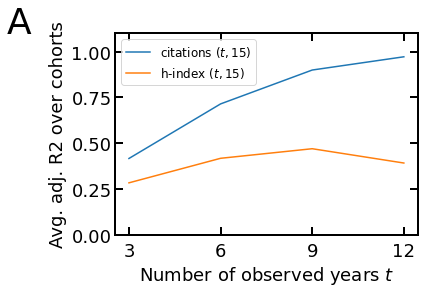

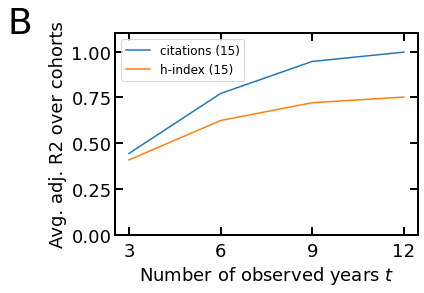

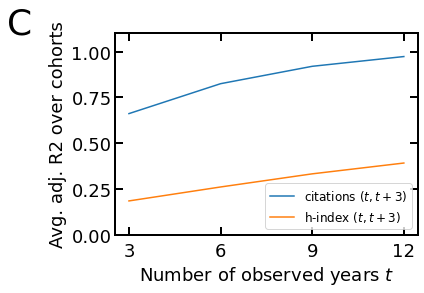

In [45]:
plot_r2_over_obs_years(r2_increase_cit_inc, r2_increase_hind_inc, 'A', ext='inc')
plot_r2_over_obs_years(r2_increase_cit_fix, r2_increase_hind_fix, 'B', ext='fix')
plot_r2_over_obs_years(r2_increase_cit_mov, r2_increase_hind_mov, 'C', ext='mov')

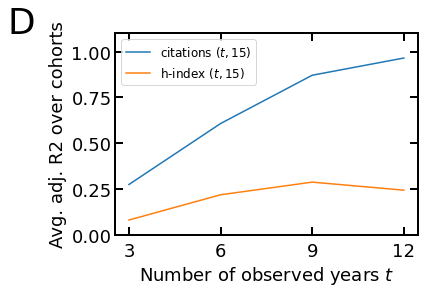

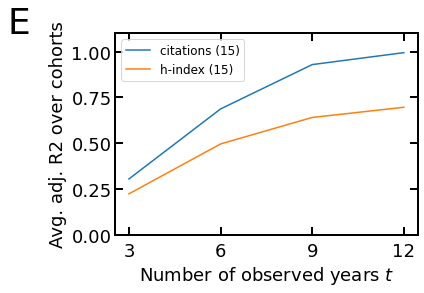

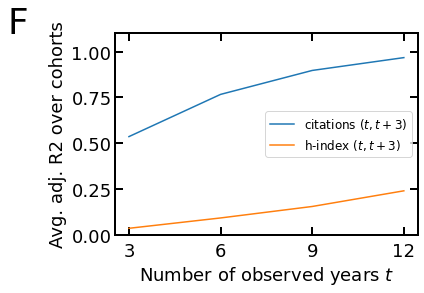

In [47]:
plot_r2_over_obs_years(r2_increase_cit_inc_nodrop, r2_increase_hind_inc_nodrop, 'D', ext='inc_nodrop')
plot_r2_over_obs_years(r2_increase_cit_fix_nodrop, r2_increase_hind_fix_nodrop, 'E', ext='fix_nodrop')
plot_r2_over_obs_years(r2_increase_cit_mov_nodrop, r2_increase_hind_mov_nodrop, 'F', ext='mov_nodrop')

#### Test predictive power over different number of years being predicted

In [ ]:
EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]

In [ ]:
def get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, DV):
    r2_increase = pd.DataFrame(index=COHORT_START_YEARS)
    for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST_EXT[1:], RECOGNITION_CUT_OFF_LIST_EXT[1:]):
        print(f'{EARLY_CAREER}, {RECOGNITION_CUT}')
        DV_ = f'{DV}_{EARLY_CAREER}_3'
        print(DV_)
        r2_increase[f'{DV}_{EARLY_CAREER}_3'] = elastic_cohort(credible_authors, get_full_vars, 3, 3, DV_)['r2']
    return r2_increase
r2_increase_cit_pred = get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'citation_increase')
r2_increase_hind_pred = get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'h_index_increase')

In [ ]:
linewidth = 2
fontsize = 18
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot([2,4,6,8,9], r2_increase_cit_pred.mean().values, label='citation inc.')
ax.plot([2,4,6,8,9], r2_increase_hind_pred.mean().values, label='h-index inc.')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xticks([2,4,6,8,9])

ax.set_xlabel('Number of years predicted ahead', fontsize=fontsize)
ax.set_ylabel('Avg. R2 over cohorts', fontsize=fontsize)
ax.set_title("Prediction R2 vs years ahead", fontsize=fontsize)
ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax.spines['left'].set_linewidth(linewidth)
ax.spines['right'].set_linewidth(linewidth)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['top'].set_linewidth(linewidth)
ax.legend(fontsize=fontsize/1.5)
plt.gcf().text(0., 0.9, 'D', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
plt.savefig('./fig/pred_r2_per_years.pdf')

In [ ]:
stop

#### predictor diffs

In [ ]:
h_index = res_cohort_full_hind
citations = res_cohort_full_cita

In [ ]:
plt.plot(h_index['r2'], label='Increase H index')
plt.plot(citations['r2'], label='Increase Citations')
print("Average difference in r squared", sum(citations['r2']-h_index['r2'])/len(h_index['r2']))
# quality was used as a feature!
plt.legend()
plt.show()

#### gender diffs

In [ ]:
# gender coefs
plt.plot(res_cohort_full_hind['gender_m'], label="Male")
plt.plot(res_cohort_full_hind['gender_f'], label="Female")
plt.legend()
plt.show()

In [ ]:
plt.plot(res_cohort_full_hind['gender_m'] - res_cohort_full_hind['gender_f'], label="Male-Female diff")
plt.plot(res_cohort_full_hind.index ,np.zeros(len(res_cohort_full_hind)))
plt.legend()
plt.show()

#### cohort size diffs

In [ ]:
fig, ax1 = plt.subplots()
# ax1.plot(results['r2'], label='r2')
ax1.plot(res_cohort_full_hind['r2'], label='adjusted r2', color='C2')
ax1.set_ylim([0,1])
ax1.set_xlabel('Years')
ax1.set_ylabel('R squared', color='C2')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(res_cohort_full_hind['cohort_size'], label='Cohort size', color='C3')
ax2.set_ylabel('Cohort size', color='C3')
ax2.legend(loc=4)
plt.show()

#### cheating diffs

In [ ]:
no_cheating = feature_table2.transpose().copy()

In [ ]:
cheat_RC5 = feature_table2.transpose().copy()

In [ ]:
cheat_quality = feature_table2.transpose().copy()

In [ ]:
# How does removing the quality affect the r squared?
plt.plot(with_quality['adj_r2'], label='With quality')
plt.plot(cheat_RC5['adj_r2'], label='With recognition year 5')
plt.plot(no_cheating['adj_r2'], label='No cheating')
print("Average difference in r squared", sum(with_quality['adj_r2']-no_cheating['adj_r2'])/len(cheat_quality))
print(np.mean)
plt.legend()
plt.show()

avg = sum(cheat_quality['adj_r2']-no_cheating['adj_r2'])/len(no_cheating)
plt.plot(cheat_quality['adj_r2']-no_cheating['adj_r2'], label='Difference')
plt.plot(no_cheating.index, [avg]*len(no_cheating), label='Average diff')
plt.title("Difference between quality(15y) and recognition(3y)")
plt.legend()
plt.show()

#### scaler diffs

In [ ]:
std_scaler = feature_table2.transpose().copy()

In [ ]:
rob_scaler = feature_table2.transpose().copy()

In [ ]:
# How does changing the scaler affect the r squared?
plt.plot(std_scaler['adj_r2'], label='Std')
plt.plot(rob_scaler['adj_r2'], label='Rob')
print("Average difference in r squared", sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(rob_scaler))
plt.legend()
plt.show()
# almost no difference

avg = sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(std_scaler)
plt.plot(std_scaler['adj_r2']-rob_scaler['adj_r2'], label='Difference')
plt.plot(std_scaler.index, [avg]*len(std_scaler), label='Average diff')
plt.legend()
plt.show()

In [ ]:
# feature_table3.transpose()

### Best feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from collections import defaultdict

In [ ]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        col_name = "Mutual Information"
    
    feat_selector = feat_selector.fit(data_frame, target)
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores 

def get_features_rfe(data_frame, target, model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

def get_features_rfecv(data_frame, target, model, cv=3):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFECV(model, step=1, cv=cv)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

In [ ]:
years = credible_authors.start_year.unique()
years = sorted(years)

In [ ]:
df = credible_authors.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    df = df.join(pd.get_dummies(df[categorical_cols]))

df.drop(categorical_cols, axis=1, inplace=True)

#### Show k best - F regression or mutual information

In [ ]:
linear = True
# true - fregression
# false - mutual info

In [ ]:
params = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params.append(show_kbest(X_year, y_year, linear, 5))

In [ ]:
params[0]

In [ ]:
selected_f = defaultdict(int)
for param in params:
    selected = param[param.Support == True]['Attribute'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE

In [ ]:
params_rfe = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[[
        #'max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfe.append(get_features_rfe(X_year, y_year, LinearRegression(),k=5))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfe:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE CV

In [ ]:
params_rfecv = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfecv.append(get_features_rfecv(X_year, y_year, LinearRegression(),cv=3))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfecv:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

### Null experiment

In [ ]:
citations_per_year = pd.read_csv('derived-data/paper-citation-count.csv', header=None, names=['pub_id', 'cit_count'])

In [ ]:
publications = pd.read_csv('derived-data/author-publications.csv')

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
# remove authors by career_len, and add start year
publications = publications.merge(credible_authors[['author', 'start_year']], on='author')

In [ ]:
publications = publications[publications.year <= publications.year + MAX_CAREER_LEN]

In [ ]:
# citations_per_year.head()

In [ ]:
publications['pub_id'] = shuffle(publications['pub_id']).reset_index(drop=True)

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
publications = publications.merge(citations_per_year, on='pub_id', how='left')
publications = publications.fillna(0)

In [ ]:
publications.sort_values(by='author').head(20)

In [ ]:
credible_authors[credible_authors.author == "a min tjoa"]['succ_after_15y']

In [ ]:
credible_authors.set_index('author', inplace=True)

In [ ]:
credible_authors['succ_shuffled'] = publications.groupby('author')['cit_count'].sum()

In [ ]:
credible_authors[['succ_shuffled', 'succ_after_15y']].head()

In [ ]:
credible_authors.columns